## 가상환경설정
    아나콘다 가상환경 설정하기
  - conda create -n med_chatbot python=3.9
  - conda activate  med_chatbot
  - pip install torch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 (cpu만 사용할때)
  - pip install python-mecab-ko
  - pip install sentence-transformers
  - pip install pandas
  - pip install matplotlib
  - pip install numpy==1.26.4 (제일 중요!(numpy가 2.0.1로 깔려있지만, 원활한 함수 사용을 위해 1.26.4로 다운그레이드 해줘야함))

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
from sentence_transformers import util
from mecab import MeCab

import json
from glob import glob

c:\Users\KOREAVC\anaconda3\envs\med_chatbot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## json 데이터 불러와 데이터 프레임 만들기
 1. glob으로 해당 폴더 모든 json 파일경로를 list로 불러옴
 2. json.load를 이용해 질문, 답변, 의도를 각각 리스트에 모두 담는다
 3. 질문, 답변, 의도에 대한 데이터 프레임을 만들고 concat으로 하나의 데이터프레임으로 합친다

In [2]:
def all_data(path1, path2):
    question_path = path1
    answer_path = path2

    return glob(question_path + '/*/*.json'), glob(answer_path + '/*/*.json')

In [5]:
q_data, a_data = all_data('./training/원천데이터/질문/치매', './training/원천데이터/답변/치매') # 경로 입력

In [6]:
# 치매 데이터 개수 확인 (질문, 답변)
len(q_data), len(a_data)

(4293, 10553)

In [7]:
with open(q_data[1000], 'r', encoding='utf-8') as file:
    json_data = json.load(file)
    print(json_data)

{'fileName': 'HC-Q-0318081', 'participantsInfo': {'participantID': 'QC088', 'gender': '남성', 'age': '20대', 'occupation': '학생', 'history': False, 'rPlace': '서울/경기/인천'}, 'disease_category': '뇌신경정신질환', 'disease_name': {'kor': '치매', 'eng': 'Dementia'}, 'intention': '약물', 'question': '약물치료를 통해 조부모님의 치매 치료 가능성을 알고 싶어요.', 'entities': [{'id': 0, 'text': '치매', 'entity': '질환명', 'position': 15}], 'num_of_words': 8}


In [8]:
q_list = []
for i in range(len(q_data)):
    with open(q_data[i], 'r', encoding='utf-8') as file:
        json_data = json.load(file)
        q_list.append(json_data['question'])

In [9]:
a_list = []
for i in range(len(q_data)):
    with open(a_data[i], 'r', encoding='utf-8') as file:
        json_data = json.load(file)
        sentence = ""
        for key in json_data['answer']:
            sentence += json_data['answer'][key]
        a_list.append(sentence)

In [10]:
i_list=[]
for i in range(len(q_data)):
    with open(q_data[i],'r',encoding='utf-8') as file:
        json_data=json.load(file)
        sentence = ""
        sentence += json_data['intention']
        i_list.append(sentence)

In [11]:
# 데이터 프레임 만들기
q_df = pd.DataFrame(q_list) # 질문 데이터 프레임
a_df = pd.DataFrame(a_list) # 답변 데이터 프레임
i_df = pd.DataFrame(i_list) # 의도 데이터 프레임
qa_df = pd.concat((q_df, a_df), axis=1) # 질문-의도 데이터 프레임
qa_df.columns=['question', 'answer']
qi_df = pd.concat((q_df, i_df), axis=1) # 질문-답변 데이터 프레임
qi_df.columns=['question', 'intention']
df = pd.concat((q_df, i_df, a_df), axis=1) # 질문-의도-답변 데이터 프레임
df.columns=['question', 'intention', 'answer']

In [12]:
# csv 파일로 저장
df.to_csv("dementia_qia.csv", sep=',') #질문, 의도, 답변 포함
qa_df.to_csv("dementia_qa.csv", sep=',') #질문, 답변
qi_df.to_csv("dementia_qi.csv", sep=',') #질문, 의도 -> 나중에 의도 분류 모델에 활용할수도 ?


In [13]:
# 형태소 분석 불러오기
from mecab import MeCab
m = MeCab()

# 각 질문마다 형태소 분석을 통해 질문당 몇 개의 단어 토큰이 들어갔는지 count리스트에 담음
count = []
for q in q_data:
    with open(q, 'r', encoding='utf-8') as file:
        json_data = json.load(file)
        count_num = len(m.morphs(json_data["question"]))
        count.append(count_num)
len(count)

4293

In [14]:
question = df['question']
answer = df['answer']
intention = df['intention']
df['answer']

0       병원에서 치매 진단을 위해 다양한 검사가 수행됩니다. 치매가 의심될 경우, 환자들은...
1       치매 진단은 전문가가 환자의 상황을 조사하고 병력 및 인지 기능 테스트, 신경 심리...
2       병원에서 치매의 진단은 단계별로 이루어지며, 다음과 같은 과정을 거칩니다.먼저, 환...
3       치매 진단을 위해 여러 가지 검사가 실시됩니다.먼저, 환자의 병력을 청취하고 문진을...
4       병원에서는 다양한 진단 절차를 거쳐 치매를 진단합니다.먼저, 치매의 증상을 정확하게...
                              ...                        
4288    알츠하이머병은 현재까지 치료 옵션이 제한적이기 때문에, 예방이 중요합니다.알츠하이머...
4289    알츠하이머병은 뇌의 인지 기능 저하를 일으키는 질병으로, 원인은 다양한 원인의 복합...
4290    치매는 노화로 인해 발생하는 인지기능의 점진적인 저하를 의미하며, 다양한 원인에 의...
4291    치매는 많은 사람들에게 영향을 미치는 질병입니다. 알츠하이머병은 노인성 치매의 흔한...
4292    치매의 원인은 다양한 요인들에 의해 발생할 수 있습니다.치매의 원인 중 하나는 뇌 ...
Name: answer, Length: 4293, dtype: object

In [15]:
# 각 질문마다 형태소 분석을 통해 답변당 몇 개의 단어 토큰이 들어갔는지 count1 리스트에 담음

count1 = []
for a in a_data:
    with open(a, 'r', encoding='utf-8') as file:
        json_data = json.load(file)
        sentence = ""
        for key in json_data["answer"].keys():
            sentence += json_data["answer"][key]
            count_num = len(m.morphs(sentence))
        count1.append(count_num)
len(count1)

10553

[ 7. 16. 19. 23. 25. 30.]


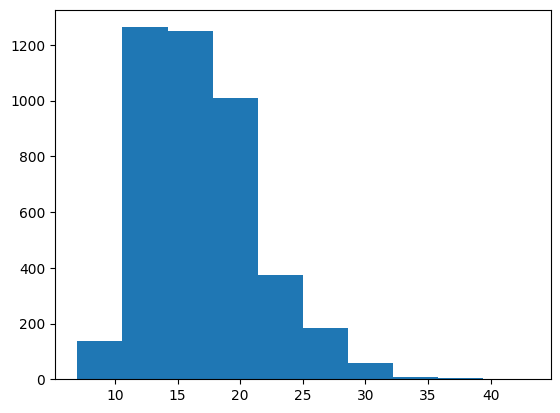

In [18]:
# 질문에 사용된 단어 개수

import matplotlib.pyplot as plt

plt.hist(count)
point_6 = np.percentile(count, q=[0, 50, 75, 90, 95, 99]) # 상위 0%, 50%, 75%, 90%, 95%, 99% 구간으로 나눠서 분포 그리기
print(point_6)

[ 63.   183.   213.   246.   273.   329.48]


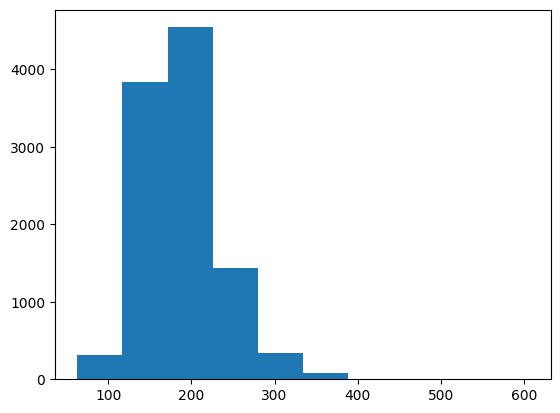

In [19]:
# 답변에 사용된 단어 개수 ()

plt.hist(count1)
point1_6 = np.percentile(count1, q=[0, 50, 75, 90, 95, 99]) # 상위 0%, 50%, 75%, 90%, 95%, 99% 구간으로 나눠서 분포 그리기
print(point1_6)

In [20]:
import re

# 한글, 영어, 숫자, 공백, ?!.,을 제외한 나머지 문자 제거
korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'

# 패턴 컴파일
normalizer = re.compile(korean_pattern)
normalizer

re.compile(r'[^ ?,.!A-Za-z0-9가-힣+]', re.UNICODE)

In [21]:
# 불용어 처리 (그런데 이미 불용어 처리된 데이터라 변화가 거의 없음)
print(f'수정 전: {question[20]}')
print(f'수정 후: {normalizer.sub("", question[20])}')
print(f'수정 전: {answer[20]}')
print(f'수정 후: {normalizer.sub("", answer[20])}')

수정 전: 치매 검진을 받는데 소요되는 시간과 노력은 얼마나 될까요?
수정 후: 치매 검진을 받는데 소요되는 시간과 노력은 얼마나 될까요?
수정 전: 치매를 진단하기 위해 다양한 방법과 검사가 사용됩니다.병원에 가면 먼저 전문의와의 상세한 면담과 신체 진찰이 이루어집니다. 전문의는 인지 기능의 변화를 확인하기 위해 환자의 기억력, 집중력, 사고력 등을 평가합니다. 혈액검사를 통해 혈액 내의 알츠하이머병 위험 인자를 확인할 수 있습니다. 신경심리검사를 통해 인지 영역의 문제가 의심될 경우 치매 여부를 확인하기 위해 혈액검사, 뇌 영상 검사, 핵의학 검사 등을 시행합니다. 아포지질단백질 유전자 검사와 비타민 및 갑상선 기능 검사도 알츠하이머병 조기 진단을 위해 실시될 수 있습니다. 혈액검사에는 알츠하이머병 위험 인자가 있는 경우 아밀로이드 양전자 방출 단층촬영이나 양전자방출단층촬영이 가능합니다. 알츠하이머병의 조기 진단을 위해 아밀로이드와 관련된 유전자 검사와 비타민 A 부족에 따른 뇌 변화를 확인하는 검사도 있습니다. 최근에는 알츠하이머병을 조기에 진단하기 위해 뇌 자기공명영상을 통해 아밀로이드 단백질과 타우 단백질의 이상을 확인할 수 있는 다양한 연구가 진행 중입니다.치매를 정확히 진단하기 위해서는 다양한 검사가 필요하며, 각 검사에 따른 적절한 조치와 치료가 필요합니다.
수정 후: 치매를 진단하기 위해 다양한 방법과 검사가 사용됩니다.병원에 가면 먼저 전문의와의 상세한 면담과 신체 진찰이 이루어집니다. 전문의는 인지 기능의 변화를 확인하기 위해 환자의 기억력, 집중력, 사고력 등을 평가합니다. 혈액검사를 통해 혈액 내의 알츠하이머병 위험 인자를 확인할 수 있습니다. 신경심리검사를 통해 인지 영역의 문제가 의심될 경우 치매 여부를 확인하기 위해 혈액검사, 뇌 영상 검사, 핵의학 검사 등을 시행합니다. 아포지질단백질 유전자 검사와 비타민 및 갑상선 기능 검사도 알츠하이머병 조기 진단을 위해 실시될 수 있습니다. 혈액검사에는 알츠하이머병 위험 인자가 있는 경우 아

In [22]:
def normalize(sentence):
    return normalizer.sub("", sentence)

normalize(question[20])

'치매 검진을 받는데 소요되는 시간과 노력은 얼마나 될까요?'

In [23]:
# 형태소 분석 돌려보기
mecab = MeCab()
mecab.morphs(normalize(question[10]))

['치매',
 '를',
 '진단',
 '하',
 '기',
 '위해',
 '어떤',
 '인지',
 '평가',
 '나',
 '뇌',
 '영상',
 '검사',
 '가',
 '사용',
 '되',
 '는지',
 '알려',
 '주',
 '세요',
 '.']

In [24]:
# 한글 전처리를 함수화
def clean_text(sentence, mecab):
    sentence = normalize(sentence)
    sentence = mecab.morphs(sentence)
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    return sentence

In [25]:
# 한글
clean_text(question[20], mecab)
clean_text(answer[20], mecab)

'치매 를 진단 하 기 위해 다양 한 방법 과 검사 가 사용 됩니다 . 병원 에 가 면 먼저 전문의 와 의 상세 한 면담 과 신체 진찰 이 이루어집니다 . 전문의 는 인지 기능 의 변화 를 확인 하 기 위해 환자 의 기억력 , 집중력 , 사고력 등 을 평가 합니다 . 혈액 검사 를 통해 혈액 내 의 알츠하이머병 위험 인자 를 확인 할 수 있 습니다 . 신경심리검사 를 통해 인지 영역 의 문제 가 의심 될 경우 치매 여부 를 확인 하 기 위해 혈액 검사 , 뇌 영상 검사 , 핵의학 검사 등 을 시행 합니다 . 아포 지질단백질 유전자 검사 와 비타민 및 갑상선 기능 검사 도 알츠하이머병 조기 진단 을 위해 실시 될 수 있 습니다 . 혈액 검사 에 는 알츠하이머병 위험 인자 가 있 는 경우 아밀로이드 양전자 방출 단층 촬영 이나 양전자 방출 단층 촬영 이 가능 합니다 . 알츠하이머병 의 조기 진단 을 위해 아밀로이드 와 관련 된 유전자 검사 와 비타민 a 부족 에 따른 뇌 변화 를 확인 하 는 검사 도 있 습니다 . 최근 에 는 알츠하이머병 을 조기 에 진단 하 기 위해 뇌 자기공명영상 을 통해 아밀로이드 단백질 과 타우 단백질 의 이상 을 확인 할 수 있 는 다양 한 연구 가 진행 중 입니다 . 치매 를 정확히 진단 하 기 위해서 는 다양 한 검사 가 필요 하 며 , 각 검사 에 따른 적절 한 조치 와 치료 가 필요 합니다 .'

In [27]:
# 질문과 답변을 형태소 분석한 결과를 각각 리스트에 모두 담음
questions = [clean_text(sent, mecab) for sent in question.values[:len(question)]]
answers = [clean_text(sent, mecab) for sent in answer.values[:len(question)]]

In [28]:
questions[:5]

['cdr 에 비해 cdr 외 에 치매 진단 에 다른 검사 방법 이 있 는지 알 고 싶 습니다 .',
 '치매 검진 을 받 기 위해 어떤 검사 를 받 아야 할까요 ?',
 '치매 의 검진 을 위해 어떤 종류 의 검사 가 주로 시행 되 나요 ?',
 '치매 검사 를 어디 에서 받 을 수 있 는지 알 고 싶 어요 .',
 '치매 검진 을 위해 어느 의사 를 찾아가 야 하 나요 ?']

In [29]:
answers[:5]

['병원 에서 치매 진단 을 위해 다양 한 검사 가 수행 됩니다 . 치매 가 의심 될 경우 , 환자 들 은 여러 가지 신 경학 적 검사 와 상담 을 받 게 됩니다 . 의사 는 면담 을 통해 환자 의 증상 과 인지 기능 의 저하 정도 를 평가 합니다 . 안저 검사 , 신 경학 적 검사 , 혈액 검사 , 소변 검사 등 이 포함 될 수 있 습니다 . 뇌 영상 검사 에서 는 mri , ct , pet 등 이 사용 됩니다 . 알츠하이머병 진단 에 유용 하 며 , 양전자 방출 단층 촬영 이나 단일 광자 방출 컴퓨터 단층 촬영 도 고려 됩니다 . 이러 한 검사 는 뇌 의 기능 적 평가 에 도움 을 줍니다 . 또한 , 양전자 방출 단층 촬영 과 단일 광자 방출 컴퓨터 단층 촬영 은 알츠하이머병 치료 의 일환 으로 사용 되 기 도 합니다 . 치매 진단 을 위해서 는 환자 의 증상 과 다양 한 신 경학 적 검사 가 필요 하 며 , 정확 한 진단 을 위해 다양 한 검사 가 고려 될 수 있 습니다 .',
 '치매 진단 은 전문가 가 환자 의 상황 을 조사 하 고 병력 및 인지 기능 테스트 , 신경 심리 검사 등 의 검사 를 통해 수행 됩니다 . 전문가 는 환자 의 증상 , 물리 적 검사 , 신경 심리 검사 등 을 평가 하 여 치매 를 진단 합니다 . 일반 적 으로 신경 심리 검사 를 통해 인지 기능 을 평가 하 고 , 혈액 검사 를 통해 알츠하이머병 의 위험 요인 이 있 는지 확인 할 수 있 습니다 . 뇌 영상 검사 를 통해 뇌 의 이상 여부 를 확인 하 고 , 뇌파 검사 , ct , mri , 단일 광자 방출 컴퓨터 단층 촬영 mri 등 의 추가 검사 를 시행 하 기 도 합니다 . 진단 은 치매 의 원인 을 파악 하 고 , 적절 한 치료 계획 을 수립 하 기 위해 중요 한 과정 입니다 . 따라서 전문가 의 정확 한 검사 와 다양 한 검사 방법 을 통해 환자 의 상황 을 정확히 평가 하 고 , 이 에 맞 는 적절 한 치료 방법 을 선택 하 는 것 이 필요 합니다 .',
 '병원 에

## seq2seq 모델 만들어보기
 1. 질문과 답변 내용을 모두 형태소 분석하여 큰 단어사전을 만듬

In [30]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [31]:
PAD_TOKEN = 0 # 빈공간 채워주는 토큰
SOS_TOKEN = 1 # 문장의 시작점을 표시하는 토큰
EOS_TOKEN = 2 # 문장의 끝을 표시하는 토큰

# 단어사전 클래스
class WordVocab():
    def __init__(self):
        self.word2index = {
            '<PAD>': PAD_TOKEN,
            '<SOS>': SOS_TOKEN, 
            '<EOS>': EOS_TOKEN,
        }
        self.word2count = {}
        self.index2word = {
            PAD_TOKEN: '<PAD>', 
            SOS_TOKEN: '<SOS>', 
            EOS_TOKEN: '<EOS>'
        }
        
        self.n_words = 3  # PAD, SOS, EOS 포함

    def add_sentence(self, sentence):
        
        # for word in sentence.split(' '):
        for word in mecab.morphs(sentence): # 문장을 형태소 분석 함수에 돌리면 각 형태소가 담긴 리스트가 나오기 때문에 바로 반복문으로 하나씩 단어사전에 추가해준다.
            self.add_word(word)

    def add_word(self, word): # word2index : 단어를 번호로 바꿔주는 딕셔너리, word2count : 해당 단어가 몇번 쓰였는지 횟수를 나타내는 딕셔너리, index2word : 번호를 단어로 바꿔주는 딕셔너리
        if word not in self.word2index: # 해당 단어가 단어사전에 없는 경우 번호를 매겨주고, 단어사전에 추가한다.
            self.word2index[word] = self.n_words 
            self.word2count[word] = 1 
            self.index2word[self.n_words] = word
            self.n_words += 1 
        else:
            self.word2count[word] += 1 

In [32]:
# 테스트로 질문과 답변을 lang1이란 단어사전 클래스를 만들어서 넣어보기
lang1 = WordVocab()
for q in question:
    lang1.add_sentence(q)
for a in answer:
    lang1.add_sentence(a)
    

In [33]:
lang1.word2index

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 'CDR': 3,
 '에': 4,
 '비해': 5,
 '외': 6,
 '치매': 7,
 '진단': 8,
 '다른': 9,
 '검사': 10,
 '방법': 11,
 '이': 12,
 '있': 13,
 '는지': 14,
 '알': 15,
 '고': 16,
 '싶': 17,
 '습니다': 18,
 '.': 19,
 '검진': 20,
 '을': 21,
 '받': 22,
 '기': 23,
 '위해': 24,
 '어떤': 25,
 '를': 26,
 '아야': 27,
 '할까요': 28,
 '?': 29,
 '의': 30,
 '종류': 31,
 '가': 32,
 '주로': 33,
 '시행': 34,
 '되': 35,
 '나요': 36,
 '어디': 37,
 '에서': 38,
 '수': 39,
 '어요': 40,
 '어느': 41,
 '의사': 42,
 '찾아가': 43,
 '야': 44,
 '하': 45,
 '는': 46,
 '병원': 47,
 '이나': 48,
 '의료': 49,
 '기관': 50,
 '알려': 51,
 '주': 52,
 '세요': 53,
 '연로': 54,
 '신데': 55,
 '최근': 56,
 '기억력': 57,
 ',': 58,
 '언어': 59,
 '력': 60,
 '판단력': 61,
 '떨어지': 62,
 '셔서': 63,
 '진료': 64,
 '는데': 65,
 '로': 66,
 '가장': 67,
 '효과': 68,
 '적': 69,
 '인': 70,
 '은': 71,
 '무엇': 72,
 '인가요': 73,
 '위한': 74,
 '인지': 75,
 '평가': 76,
 '나': 77,
 '뇌': 78,
 '영상': 79,
 '어떻게': 80,
 '진행': 81,
 '예방': 82,
 '가족': 83,
 '협력': 84,
 '해야': 85,
 '사용': 86,
 '핵심': 87,
 '포인트': 88,
 '와': 89,
 '대해': 90,
 '주요': 91,
 '절차': 92

In [34]:
# 문장 하나 가져와서 단어사전에 추가해서 확인 (테스트용 코드)
print(f'원문: {questions[550]}')
lang = WordVocab()
lang.add_sentence(questions[550])
print('==='*10)
print('[단어사전]')
print('***'*10)
print(lang.word2index)

원문: 치매 환자 를 위한 식단 조절 의 중요 성 과 이점 은 무엇 인가요 ?
[단어사전]
******************************
{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '치매': 3, '환자': 4, '를': 5, '위한': 6, '식단': 7, '조절': 8, '의': 9, '중요': 10, '성': 11, '과': 12, '이점': 13, '은': 14, '무엇': 15, '인가요': 16, '?': 17}


In [35]:
# 문장 생성 테스트(나중에 데이터셋 만들때 필요한 과정)

max_length = 50 # 문장을 담을 길이를 정하기
sentence_length = 30 # 입력할 문장길이

sentence_tokens = np.random.randint(low=3, high=100, size=(sentence_length,)) # 랜덤으로 단어 뽑아오기(3번~100까지)
sentence_tokens = sentence_tokens.tolist() 
print(f'Generated Sentence: {sentence_tokens}')

sentence_tokens = sentence_tokens[:(max_length-1)]

token_length = len(sentence_tokens)

# 문장의 맨 끝부분에 <EOS> 토큰 추가
sentence_tokens.append(2)

for i in range(token_length, max_length-1):
    # 나머지 빈 곳에 <PAD> 토큰 추가
    sentence_tokens.append(0)

print(f'Output: {sentence_tokens}')
print(f'Total Length: {len(sentence_tokens)}')

Generated Sentence: [27, 15, 81, 35, 12, 96, 85, 50, 92, 94, 7, 56, 95, 9, 4, 34, 53, 71, 84, 16, 47, 82, 17, 79, 62, 46, 14, 78, 63, 86]
Output: [27, 15, 81, 35, 12, 96, 85, 50, 92, 94, 7, 56, 95, 9, 4, 34, 53, 71, 84, 16, 47, 82, 17, 79, 62, 46, 14, 78, 63, 86, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total Length: 50


## 학습용 데이터 만들기(여기가 중요!)
 1. csv파일에서 질문, 답변 데이터를 읽어와 데이터 프레임을 만듬
 2. 질문, 답변내용에서 형태소 분석(mecab 사용)을 이용해 단어사전을 만듬
 3. 질문내용은 30개 토큰, 답변 내용은 300개 토큰을 사용 (q_max_length, a_max_length로 조절할 수 있음)
 4. 입력 문장을 단어사전을 이용해 숫자로 변환한 후 리스트로 만듬 ex) "치매에 좋은 운동은 뭐가 있나요?" -> [치매에, 좋은, 운동, 은, 뭐가, 있나요?] -> [2, 4, 5, 6, 7, 8, 0.....,0](길이가 30인 숫자 리스트로 변환)
 5. 답변 문장도 같은 형식으로 길이가 300인 리스트로 변환
 6. 의도는 각 단어마다 번호를 매겨 하나의 숫자로 변환
 7. 출력은 {"answer" : 답변내용문자열, "intention" : 의도에 해당하는 숫자} 형태의 딕셔너리로 만들었음
 8. 그리고 각 input값과 출력값은 학습시키려면 tensor로 변환시켜줘야하기 때문에, torch.tensor()함수로 감싸서 텐서형태로 만들어줌

In [36]:
class TextDataset(Dataset):
    def __init__(self, csv_path, min_length=3, max_length1=50, q_max_length=30, a_max_length=300):
        super(TextDataset, self).__init__()
        # data_dir = 'data'
        
        # TOKEN 정의
        self.PAD_TOKEN = 0 # Padding 토큰
        self.SOS_TOKEN = 1 # SOS 토큰
        self.EOS_TOKEN = 2 # EOS 토큰
        
        self.tagger = MeCab()   # 형태소 분석기
        self.max_length1 = max_length # 한 문장의 최대 길이 지정
        self.q_max_length = q_max_length # 질문 길이 최대 지정
        self.a_max_length = a_max_length # 답변 길이 최대 지정
        
        # CSV 데이터 로드
        # df = pd.read_csv(os.path.join(data_dir, csv_path))
        df=pd.read_csv('dementia1.csv') # 질문, 답변, 의도가 저장된 csv파일
        # 한글 정규화
        korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
        self.normalizer = re.compile(korean_pattern)
        
        # src: 질의, itn: 의도 tgt: 답변
        src_clean = []
        itn_clean = [] 
        tgt_clean = []
        
        # 단어 사전 생성
        wordvocab = WordVocab()
        itn_label = {"검진" : 0, "식이, 생활" : 1, "약물" : 2, "예방" : 3, "운동" : 4, "원인" : 5, "정의" : 6, "증상" : 7, "진단" : 8, "치료" : 9}
        for _, row in df.iterrows():
            src = row['question']
            itn = row['intention']
            tgt = row['answer']
            
            # 한글 전처리
            src = self.clean_text(src)
            tgt = self.clean_text(tgt)
            
            if len(src.split()) > min_length and len(tgt.split()) > min_length:
                # 최소 길이를 넘어가는 문장의 단어만 추가
                wordvocab.add_sentence(src)
                wordvocab.add_sentence(tgt)
                src_clean.append(src)          
                tgt_clean.append(tgt)
            itn_clean.append(itn_label[itn])
        
        self.srcs = src_clean
        self.itns = itn_clean
        self.tgts = tgt_clean
        self.wordvocab = wordvocab
    
    def normalize(self, sentence):
        # 정규표현식에 따른 한글 정규화
        return self.normalizer.sub("", sentence)

    def clean_text(self, sentence):
        # 한글 정규화
        sentence = self.normalize(sentence)
        # 형태소 처리
        sentence = self.tagger.morphs(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.lower()
        return sentence
    
    def texts_to_sequences(self, sentence):
        # 문장 -> 시퀀스로 변환
        return [self.wordvocab.word2index[w] for w in mecab.morphs(sentence)]
    
        # return [self.wordvocab.word2index[w] for w in sentence.split()]

    def pad_sequence(self, sentence_tokens, max_length):
        # 문장의 맨 끝 토큰은 제거
        sentence_tokens = sentence_tokens[:(max_length-1)]
        token_length = len(sentence_tokens)

        # 문장의 맨 끝부분에 <EOS> 토큰 추가
        sentence_tokens.append(self.EOS_TOKEN)

        for i in range(token_length, (max_length-1)):
            # 나머지 빈 곳에 <PAD> 토큰 추가
            sentence_tokens.append(self.PAD_TOKEN)
        return sentence_tokens
    
    def __getitem__(self, idx):
        # 데이터프레임 구조
        #------------------------------------
        # 1 | 질문내용 | 의도 | 답변내용 
        # 2 | 질문내용 | 의도 | 답변내용 
        # ...
        # 마지막 idx | 질문내용 | 의도 | 답변내용 
        #-------------------------------------
        # 여기서 한줄씩 뽑아서 학습용 데이터셋을 구성
        # inputs = self.srcs[idx]
        
        # 입력형태 만들기
        inputs_sequences = self.texts_to_sequences(self.srcs[idx])
        inputs_padded = self.pad_sequence(inputs_sequences, self.q_max_length)
        
        # outputs = self.tgts[idx]
        # 출력 형태 만들기
        outputs = {}
        outputs_sequences = self.texts_to_sequences(self.tgts[idx])
        outputs_padded = self.pad_sequence(outputs_sequences, self.a_max_length)
        outputs['answer'] = torch.tensor(outputs_padded)
        outputs['intention'] = torch.tensor(self.itns[idx])
        
        return torch.tensor(inputs_padded), outputs
        # return torch.tensor(inputs_padded), torch.tensor(outputs_padded)
    
    def __len__(self):
        return len(self.srcs)

In [37]:
# 한 문장의 최대 단어길이를 300로 설정
MAX_LENGTH = 300 # 안써도 되는 파라미터
Q_MAX_LENGTH = 30 # 질문 문장 최대 30개 토큰 사용
A_MAX_LENGTH = 300 # 답변 문장 최대 300개 토큰 사용

dataset = TextDataset('dementia1.csv', min_length=3, max_length1=MAX_LENGTH, q_max_length=Q_MAX_LENGTH, a_max_length=A_MAX_LENGTH)

In [38]:
# 단어사전 등록된 단어 개수
dataset.wordvocab.n_words

3471

In [39]:
# 데이터셋으로 변환한 결과 확인
dataset[0]

(tensor([ 3,  4,  5,  3,  6,  4,  7,  8,  9,  4, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20,  2,  0,  0,  0,  0,  0,  0,  0,  0]),
 {'answer': tensor([21, 22, 23,  9, 24, 25, 26, 27, 11, 28, 29, 30, 20, 23, 28, 31, 32, 33,
          34, 35, 36, 37, 38, 39, 40, 41, 42, 11, 43, 44, 24, 45, 46, 30, 20, 47,
          48, 49, 24, 50, 35, 51, 52, 53, 54, 55, 51, 56, 57, 58, 59, 60, 20, 61,
          11, 34, 40, 41, 42, 11, 34, 62, 11, 34, 63, 11, 64, 13, 65, 32, 66, 14,
          19, 20, 67, 68, 11, 22, 48, 69, 34, 70, 34, 71, 64, 13, 72, 30, 20, 73,
           9,  4, 74, 75, 76, 34, 77, 78, 79, 80, 81, 82, 83, 78, 84, 79, 80, 85,
          86, 30, 20, 87, 27, 11, 48, 67, 51, 55, 42, 59,  4, 88, 24, 89, 20, 90,
          34, 77, 78, 79, 80, 53, 82, 83, 78, 84, 79, 80, 37, 73, 91, 51, 92, 93,
          72, 94, 95, 85, 60, 20, 23,  9, 24, 96, 48, 35, 51, 52, 53, 26, 27, 40,
          41, 42, 11, 28, 97, 75, 76, 34, 98, 27,  9, 24, 25, 26, 27, 11, 28, 86,
          32, 66, 14, 19, 20, 

In [40]:
# 10번째 데이터 임의 추출
x, y = dataset[10]

In [41]:
x

tensor([ 23,  58,   9,  75,  95,  25, 100,  54,  59, 259,  67,  68,  11,  28,
         72,  94,  15, 209, 210, 211,  20,   2,   0,   0,   0,   0,   0,   0,
          0,   0])

In [42]:
print(f'x shape: {x.shape}')
print(x)

print(f'y shape: {y["answer"].shape}')
print(y)

x shape: torch.Size([30])
tensor([ 23,  58,   9,  75,  95,  25, 100,  54,  59, 259,  67,  68,  11,  28,
         72,  94,  15, 209, 210, 211,  20,   2,   0,   0,   0,   0,   0,   0,
          0,   0])
y shape: torch.Size([300])
{'answer': tensor([ 23,  58,   9,  75,  95,  96,  48,  38,  39,  11,  28,  97,  60,  20,
        176,  53, 198,  11,  58,  50,  23,  51, 189, 190,  24,  59,  75,  46,
         30,  20,  13,   4, 123, 143, 110, 111,  11,  58,  50,  54,  55,  24,
         59,  75,  46,  30,  20, 110, 111,  11,  48,  23,  51,  54,  55,  56,
         57,  58,  98,  75,  46, 197,  75,  48, 178,  72,  30,  20,  90,  62,
         11,  34,  67,  68,  11,  34, 168,  11,  34, 188,  11,  64,  51,  11,
         85, 160,  94, 290,  23,  51, 125,  24, 291,  75,  95,  25,  72,  30,
         20, 218, 292, 220,  11,  34, 221,  11,  34, 223,  55,  11,  34, 293,
         11,  64,  85,   9,   4,  88,  13,  30,  20,  87,  27,  26,  27,  11,
         58,  50,  47,  48,  23,  51, 125,  24, 126,  75,  

In [43]:
# 80%의 데이터를 train에 할당합니다.
train_size = int(len(dataset) * 0.8)
train_size

3434

In [44]:
# 나머지 20% 데이터를 test에 할당합니다.
test_size = len(dataset) - train_size
test_size

859

In [45]:
from torch.utils.data import random_split

# 랜덤 스플릿으로 분할을 완료합니다.
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [46]:
from torch.utils.data import DataLoader, SubsetRandomSampler

# 배치사이즈 : 16 (16개씩 묶음)
train_loader = DataLoader(train_dataset, 
                          batch_size=16, 
                          shuffle=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=16, 
                         shuffle=True)

In [47]:
train_dataset[0]

(tensor([ 23, 162,  24, 163, 297, 514,  81, 433, 241,  12,   4, 263, 209, 210,
         211,  20,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0]),
 {'answer': tensor([  23,  162,   37,  825,   28,  296,   22,  833,  119,   66,   14,   48,
            26,   27,   12,   24,   50,  236,   20,  148,   34,  433,   27,  811,
            24,  555,  275,   60,   20,   26,   27, 1780,   43, 1137,   24, 1040,
            75,  114,  221,   53, 1426,   34, 2020,   64,  900,   58, 1120,  841,
            75,   48,  137,   13,  130,   60,   20,   90,   34,  127,   27,  708,
            24, 1072,   75,   48,  137,   13,  570,   19,   20,  198,   42,  419,
            37,   67,  419,   24,  888,   75,   17,   23,   51,  116,   24,  832,
            66,   14,   19,   20,  422,  405,   42,  217,  433,   99,   53,   47,
            43,   51, 1041,   27,   44,   85,   23,  162,    4,  464,   88,   13,
            30,   20,   23,  162,   24,   25,  296,   22,  808,   42,   9

In [48]:
# 1개의 배치 데이터를 추출합니다.
x, y = next(iter(train_loader))

In [49]:
x, y

(tensor([[  23,   91,    4,   88,   13,   94,   48,  600,   37,  100,  137,   36,
            13,   14,  442,  103,    2,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0],
         [  23,   91,    4,  100,  138,   51,  600,   13,   72,   94,   15,  209,
           210,  211,   20,    2,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0],
         [1454,   43,  111,   91,  375,  100,  137,   13,   23,  181, 2245,  475,
            24,  490,   75,   48,  178,    4,  492,  243,   42,  628,  103,    2,
             0,    0,    0,    0,    0,    0],
         [  23,    4, 1690,   35,   28,  708,   24,   50,  244,   24,  272,   24,
            66,   14,   15,   16,   17,   18,  174,   20,    2,    0,    0,    0,
             0,    0,    0,    0,    0,    0],
         [1601, 2266,  190,   23,   91,    4,   72,   94,   48,  600,  375,  100,
           137,   36,   13,  243,   42,   54,   16,   17,   18,  174,   20

In [50]:
# shape: (batch_size, sequence_length)
x.shape, y["answer"].shape

(torch.Size([16, 30]), torch.Size([16, 300]))

## 모델 만들기
 - 기본적으로 seq-to-seq 는 encoder - decoder 구조로 되어있음
 - 하나의 단어를 임베딩을 통해 벡터로 만들어줌
 - 단어사전의 있는 모든 단어를 임베딩을 해줌
 - 배치사이즈가 16개이므로, 질문입력 사이즈는(16x30), 답변 입력사이즈는(16x300)
 - 여기에 임베딩 차원이 64이므로(단어 하나를 64개의 무언가로 표현) 각각 인코더를 통과하면 (16x30x64),(16x300x64)의 사이즈가 된다.
 - gru의 히든 레이어 사이즈가 32이므로, 임베딩을 통과한 데이터가 64에서 32로 줄어듬 (16x30x32), (16x300x32)
 - -------여기부터는 더 공부해가지고 올게요--------------

In [51]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers):
        super(Encoder, self).__init__()
        
        # 단어 사전의 개수 지정
        self.num_vocabs = num_vocabs
        # 임베딩 레이어 정의 (number of vocabs, embedding dimension)
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        # GRU (embedding dimension)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False)
        
    def forward(self, x):
        x = self.embedding(x).permute(1, 0, 2)
        output, hidden = self.gru(x)
        return output, hidden

In [52]:
# Embedding Layer의 입/출력 shape에 대한 이해

embedding_dim = 64 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

# x의 shape을 변경합니다.
# (batch_size, sequence_length) => (sequence_length, batch_size)
embedded = embedding(x)

print(x.shape)
print(embedded.shape)
# input:  (sequence_length, batch_size)
# output: (sequence_length, batch_size, embedding_dim)

torch.Size([16, 30])
torch.Size([16, 30, 64])


In [53]:
embedded = embedded.permute(1, 0, 2)
print(embedded.shape)
# (sequence_length, batch_size, embedding_dim)

torch.Size([30, 16, 64])


In [54]:
hidden_size = 32   

gru = nn.GRU(embedding_dim,      # embedding 차원
             hidden_size, 
             num_layers=1, 
             bidirectional=False)

# input       : (sequence_length, batch_size, embedding_dim)
# h0          : (Bidirectional(1) x number of layers(1), batch_size, hidden_size)
o, h = gru(embedded, None)

print(o.shape)
print(h.shape)
# output      : (sequence_length, batch_size, hidden_size x bidirectional(1))
# hidden_state: (bidirectional(1) x number of layers(1), batch_size, hidden_size)

torch.Size([30, 16, 32])
torch.Size([1, 16, 32])


In [56]:
NUM_VOCABS = dataset.wordvocab.n_words
print(f'number of vocabs: {NUM_VOCABS}')

number of vocabs: 3471


In [57]:
# Encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=32, 
                  embedding_dim=64, 
                  num_layers=1)

In [58]:
# Encoder에 x 통과 후 output, hidden_size 의 shape 확인
# input(x)    : (batch_size, sequence_length)
o, h = encoder(x)

print(o.shape)
print(h.shape)
# output      : (sequence_length, batch_size, hidden_size x bidirectional(1))
# hidden_state: (bidirectional(1) x number of layers(1), batch_size, hidden_size

torch.Size([30, 16, 32])
torch.Size([1, 16, 32])


In [59]:
class Decoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers=1, dropout=0.2):
        super(Decoder, self).__init__()
        # 단어사전 개수
        self.num_vocabs = num_vocabs
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False)
        
        # 최종 출력은 단어사전의 개수
        self.fc = nn.Linear(hidden_size, num_vocabs)
        
    def forward(self, x, hidden_state):
        x = x.unsqueeze(0) # (1, batch_size) 로 변환
        embedded = F.relu(self.embedding(x))
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded, hidden_state)
        output = self.fc(output.squeeze(0)) # (sequence_length, batch_size, hidden_size(32) x bidirectional(1))
        return output, hidden

In [60]:
#Embedding Layer의 입/출력 shape
x = torch.abs(torch.randn(size=(1, 16)).long())
print(x)
x.shape
# batch_size = 16 이라 가정했을 때,
# (1, batch_size)
# 여기서 batch_size => (1, batch_size) 로 shape 변환을 선행

tensor([[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]])


torch.Size([1, 16])

In [61]:
embedding_dim = 64 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

embedded = embedding(x)
embedded.shape
# embedding 출력
# (1, batch_size, embedding_dim)

torch.Size([1, 16, 64])

In [62]:
 #GRU Layer의 입/출력 shape에 대한 이해
hidden_size = 32

gru = nn.GRU(embedding_dim, 
             hidden_size, 
             num_layers=1, 
             bidirectional=False, 
             batch_first=False, # batch_first=False로 지정
            )

o, h = gru(embedded)

print(o.shape)
# output shape: (sequence_length, batch_size, hidden_size(32) x bidirectional(1))
print(h.shape)
# hidden_state shape: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([1, 16, 32])
torch.Size([1, 16, 32])


In [63]:
# 최종 출력층(FC) shape에 대한 이해
fc = nn.Linear(32, NUM_VOCABS) # 출력은 단어사전의 개수로 가정

output = fc(o[0])

print(o[0].shape)
print(output.shape)
# input : (batch_size, output from GRU)
# output: (batch_size, output dimension)

torch.Size([16, 32])
torch.Size([16, 3471])


In [64]:
#인코더 -> 디코더 입출력 shape
decoder = Decoder(num_vocabs=dataset.wordvocab.n_words, 
                  hidden_size=32, 
                  embedding_dim=64, 
                  num_layers=1)

In [65]:
x, y = next(iter(train_loader))

o, h = encoder(x)

print(o.shape, h.shape)
# output      : (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
# hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([30, 16, 32]) torch.Size([1, 16, 32])


In [66]:
# ***************
x = torch.abs(torch.full(size=(16,), fill_value=SOS_TOKEN, dtype=torch.long))
print(x)
x.shape

# batch_size = 16 이라 가정(16개의 SOS 토큰)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


torch.Size([16])

In [67]:
embedding_dim = 64 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

embedded = embedding(x)
embedded.shape
# embedding 출력
# (1, batch_size, embedding_dim)

torch.Size([16, 64])

In [68]:
x

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [69]:
decoder_output, decoder_hidden = decoder(x, h)
decoder_output.shape, decoder_hidden.shape
# (batch_size, num_vocabs), (1, batch_size, hidden_size)

(torch.Size([16, 3471]), torch.Size([1, 16, 32]))

In [70]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, inputs, outputs, teacher_forcing_ratio=0.5):
        # inputs : (batch_size, sequence_length)
        # outputs: (batch_size, sequence_length)
        
        batch_size, output_length = outputs.shape
        output_num_vocabs = self.decoder.num_vocabs
        
        # 리턴할 예측된 outputs를 저장할 임시 변수
        # (sequence_length, batch_size, num_vocabs)
        predicted_outputs = torch.zeros(output_length, batch_size, output_num_vocabs).to(self.device)
        
        # 인코더에 입력 데이터 주입, encoder_output은 버리고 hidden_state 만 살립니다. 
        # 여기서 hidden_state가 디코더에 주입할 context vector 입니다.
        # (Bidirectional(1) x number of layers(1), batch_size, hidden_size)
        _, decoder_hidden = self.encoder(inputs)
        
        # (batch_size) shape의 SOS TOKEN으로 채워진 디코더 입력 생성********************
        decoder_input = torch.full((batch_size,), SOS_TOKEN, dtype=torch.long, device=self.device)
        
        # 순회하면서 출력 단어를 생성합니다.
        # 0번째는 SOS TOKEN이 위치하므로, 1번째 인덱스부터 순회합니다.
        for t in range(0, output_length):
            # decoder_input : 디코더 입력 (batch_size) 형태의 SOS TOKEN로 채워진 입력
            # decoder_output: (batch_size, num_vocabs)
            # decoder_hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size), context vector와 동일 shape
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            # t번째 단어에 디코더의 output 저장
            predicted_outputs[t] = decoder_output
            
            # teacher forcing 적용 여부 확률로 결정
            # teacher forcing 이란: 정답치를 다음 RNN Cell의 입력으로 넣어주는 경우. 수렴속도가 빠를 수 있으나, 불안정할 수 있음
            teacher_force = random.random() < teacher_forcing_ratio
            
            # top1 단어 토큰 예측
            top1 = decoder_output.argmax(1) 
            
            # teacher forcing 인 경우 ground truth 값을, 그렇지 않은 경우, 예측 값을 다음 input으로 지정
            decoder_input = outputs[:, t] if teacher_force else top1
        
        return predicted_outputs.permute(1, 0, 2) # (batch_size, sequence_length, num_vocabs)로 변경

In [71]:
#Seq2Seq 입출력 확인
# Encoder 정의
encoder = Encoder(num_vocabs=dataset.wordvocab.n_words, 
                       hidden_size=32, 
                       embedding_dim=64, 
                       num_layers=1)
# Decoder 정의
decoder = Decoder(num_vocabs=dataset.wordvocab.n_words, 
                       hidden_size=32, 
                       embedding_dim=64, 
                       num_layers=1)
# Seq2Seq 정의
seq2seq = Seq2Seq(encoder, decoder, 'cpu')

In [72]:
x, y = next(iter(train_loader))
# print(x.shape, y.shape)
# (batch_size, sequence_length), (batch_size, sequence_length)

In [73]:
x

tensor([[  23, 1047,  100,  615,    4,  177,   75,   48,  330,  245,  103,  602,
           43,  181,   75,  114,  265,  399,  210,  211,   20,    2,    0,    0,
            0,    0,    0,    0,    0,    0],
        [  23,   91,   58,   25,  100,   91,   12,   13,  115,   42,   93,   72,
           94,  140,  103,    2,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [1860,   28, 2398,    4, 2157,   48, 1634,   24, 2835,   48,   52,   13,
           14,   24,  413,   34,  100,  207,  208,   22,    9,   11,   58,   45,
           24,   66,   14,  442,  103,    2],
        [ 600,   91,   51,  243,   58,  609,   95,   25,  601,   12,   13,   10,
           33,   28,   14,  140,  103,    2,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [2211,  687,   28,   23,    4, 1675,   46,   94,   48,  318,  125,   36,
           37,  244,  245,  103,    2,    0,    0,    0,    0,    0,    0,    0,
      

In [74]:
y

{'answer': tensor([[ 23,  48, 804,  ...,   0,   0,   0],
         [ 23,  48, 346,  ...,   0,   0,   0],
         [ 23,  35, 256,  ...,   0,   0,   0],
         ...,
         [ 23,  48, 316,  ...,   0,   0,   0],
         [ 23,  35,  28,  ...,   0,   0,   0],
         [ 23,  35,  58,  ...,   0,   0,   0]]),
 'intention': tensor([6, 9, 8, 2, 5, 7, 1, 3, 3, 2, 8, 0, 4, 9, 7, 7])}

In [75]:
import random
output = seq2seq(x, y['answer'])
# print(output.shape)
# (batch_size, sequence_length, num_vocabs)

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NUM_VOCABS = dataset.wordvocab.n_words
HIDDEN_SIZE = 512
EMBEDDIMG_DIM = 256

print(f'num_vocabs: {NUM_VOCABS}\n======================')

# Encoder 정의
encoder = Encoder(num_vocabs=NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDIMG_DIM, 
                  num_layers=1)
# Decoder 정의
decoder = Decoder(num_vocabs=NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDIMG_DIM, 
                  num_layers=1)

# Seq2Seq 생성
# encoder, decoder를 device 모두 지정
model = Seq2Seq(encoder.to(device), decoder.to(device), device)
print(model)

num_vocabs: 3471
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3471, 256)
    (gru): GRU(256, 512)
  )
  (decoder): Decoder(
    (embedding): Embedding(3471, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (gru): GRU(256, 512)
    (fc): Linear(in_features=512, out_features=3471, bias=True)
  )
)


In [77]:
encoder

Encoder(
  (embedding): Embedding(3471, 256)
  (gru): GRU(256, 512)
)

In [79]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

## 학습 및 모델 튜닝
 - 학습시키면서 성능 향상을 위해 하이퍼 파라미터 조정

In [80]:
# 훈련에 적용할 하이퍼파라미터 설정

LR = 1e-3
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

es = EarlyStopping(patience=5, 
                   delta=0.001, 
                   mode='min', 
                   verbose=True
                  )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=2,
                                                 threshold_mode='abs',
                                                 min_lr=1e-8, 
                                                 verbose=True)

In [81]:
# train 함수 정의
def train(model, data_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0
    
    for x, y in data_loader:
        x, y = x.to(device), y['answer'].to(device) # tensor로만 학습이 되기때문에, 딕셔너리안에 있는 답변에 해당하는 값을 가져와야함
        # x, y['answer'], y['intention'] = x.to(device), y['answer'].to(device), y['intention'].to(device)

        optimizer.zero_grad() # 초기화
        
        # output: (batch_size, sequence_length, num_vocabs)
        output = model(x, y)
        output_dim = output.size(2)
        
        # 1번 index 부터 슬라이싱한 이유는 0번 index가 SOS TOKEN 이기 때문
        # (batch_size*sequence_length, num_vocabs) 로 변경
        output = output.reshape(-1, output_dim)
        
        # (batch_size*sequence_length) 로 변경
        y = y.view(-1)
        
        # Loss 계산
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
        
    return running_loss / len(data_loader)

In [82]:
# evaluation 함수 정의
def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    
    eval_loss = 0
    
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y['answer'].to(device)
            # x, y['answer'], y['intention'] = x.to(device), y['answer'].to(device), y['intention'].to(device)
            output = model(x, y)
            output_dim = output.size(2)
            output = output.reshape(-1, output_dim)
            y = y.view(-1)
            
            # Loss 계산
            loss = loss_fn(output, y)
            
            eval_loss += loss.item() * x.size(0)
            
    return eval_loss / len(data_loader)

In [83]:
# 랜덤 샘플링 후 결과 추론
def sequence_to_sentence(sequences, index2word):
    outputs = []
    for p in sequences:

        word = index2word[p]
        if p not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]:
            outputs.append(word)
        if word == EOS_TOKEN:
            break
    return ' '.join(outputs)

In [84]:
# sequence를 다시 문장으로 바꾸어 문장 형식으로 출력하기 위한 함수

def random_evaluation(model, dataset, index2word, device, n=10):
    
    n_samples = len(dataset)
    indices = list(range(n_samples))
    np.random.shuffle(indices)      # Shuffle
    sampled_indices = indices[:n]   # Sampling N indices
    
    # 샘플링한 데이터를 기반으로 DataLoader 생성
    sampler = SubsetRandomSampler(sampled_indices)
    sampled_dataloader = DataLoader(dataset, batch_size=10, sampler=sampler)
    
    model.eval()
    with torch.no_grad():
        for x, y in sampled_dataloader:
            x, y = x.to(device), y['answer'].to(device)      
            # x, y['answer'], y['intention'] = x.to(device), y['answer'].to(device), y['intention'].to(device)  
            output = model(x, y, teacher_forcing_ratio=0)
            # output: (number of samples, sequence_length, num_vocabs)
            
            preds = output.detach().cpu().numpy()
            x = x.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            
            for i in range(n):
                print(f'질문   : {sequence_to_sentence(x[i], index2word)}')
                print(f'답변   : {sequence_to_sentence(y[i], index2word)}')
                print(f'예측답변: {sequence_to_sentence(preds[i].argmax(1), index2word)}')
                print('==='*10)

In [85]:
#  훈련 시작
NUM_EPOCHS = 5
STATEDICT_PATH = 'seq2seq-chatbot-kor.pt'

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    loss = train(model, train_loader, optimizer, loss_fn, device)
    
    val_loss = evaluate(model, test_loader, loss_fn, device)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), STATEDICT_PATH)
    
    if epoch % 5 == 0:
        print(f'epoch: {epoch+1}, loss: {loss:.4f}, val_loss: {val_loss:.4f}')
    
    # Early Stop
    es(loss)
    if es.early_stop:
        break
    
    # Scheduler
    scheduler.step(val_loss)
                   
model.load_state_dict(torch.load(STATEDICT_PATH))
torch.save(model.state_dict(), f'seq2seq-chatbot-kor-{best_loss:.4f}.pt')

epoch: 1, loss: 45.9442, val_loss: 37.2873
[EarlyStopping] (Update) Best Score: 45.94422
[EarlyStopping] (Update) Best Score: 35.74989
[EarlyStopping] (Update) Best Score: 33.07088
[EarlyStopping] (Update) Best Score: 31.55208
[EarlyStopping] (Update) Best Score: 30.73681


In [86]:
# 문장을 입력받아 답을 출력하는 함수

def predict(model, sentence, index2word, device, n=10):

    model.eval()
    with torch.no_grad():
        input_tokens = dataset.texts_to_sequences(dataset.clean_text(sentence))
        input_padded = dataset.pad_sequence(input_tokens, dataset.q_max_length)
    
        # 입력 데이터를 텐서로 변환
        input_tensor = torch.tensor(input_padded).unsqueeze(0).to(device)  # 배치 차원을 추가하고 텐서로 변환
        output_tensor =  torch.tensor([0 for i in range(300)]).unsqueeze(0).to(device)
        # x, y['answer'], y['intention'] = x.to(device), y['answer'].to(device), y['intention'].to(device)  
        output = model(input_tensor, output_tensor, teacher_forcing_ratio=0)
        # output: (number of samples, sequence_length, num_vocabs)
        
        # preds = output.detach().cpu().numpy()
        # x = x.detach().cpu().numpy()
        # y = y.detach().cpu().numpy()
        
        output_tokens = output.detach().squeeze(0).cpu().numpy()  # 배치 차원을 제거하고 넘파이 배열로 변환
        predicted_tokens = np.argmax(output_tokens, axis=1)  # 각 시퀀스의 최대 확률 토큰을 선택
        
        response_sentence = sequence_to_sentence(predicted_tokens, index2word)  # 토큰 시퀀스를 문자열로 변환
        
        return response_sentence

In [89]:
sentence = "치매의 증상 중 하나로 현관 비밀 번호 생각이 안 나는 것이 포함되는 것이 있는지 알려주세요"
response = predict(model, sentence, dataset.wordvocab.index2word, device)
print(f'챗봇 응답: {response}')

챗봇 응답: 치매 환자 에게 운동 은 다양 한 이점 을 제공 합니다 . 치매 환자 에게 는 운동 은 인지 기능 을 개선 하 고 일상 생활 능력 을 향상 시키 는 데 도움 이 됩니다 . 운동 은 치매 환자 의 일상 생활 능력 을 향상 시키 고 데 도움 이 됩니다 . 운동 은 치매 환자 의 일상 생활 능력 을 향상 시키 고 데 도움 이 됩니다 . 운동 은 치매 환자 의 일상 생활 능력 을 향상 시키 고 데 도움 이 됩니다 . 운동 은 치매 환자 의 일상 생활 능력 을 향상 시키 고 데 도움 이 됩니다 . 운동 은 치매 환자 의 일상 생활 능력 을 향상 시키 고 데 도움 이 됩니다 . 운동 은 치매 환자 의 일상 생활 능력 을 향상 시키 고 데 도움 이 됩니다 . 치매 환자 에게 는 운동 운동 은 신체 운동 , 인지 기능 저하 와 같 은 운동 을 을 하 는 데 도움 이 됩니다 . 치매 환자 에게 는 운동 운동 은 신체 운동 , 인지 기능 저하 와 의 위험 을 감소 시키 는 데 도움 이 됩니다 . 치매 환자 에게 는 운동 운동 은 치매 환자 의 일상 생활 능력 을 향상 시키 는 데 도움 이 됩니다 . 치매 환자 에게 는 운동 운동 은 치매 환자 의 일상 생활 능력 을 향상 시키 고 데 도움 이 될 수 있 습니다 .


In [94]:
device

device(type='cpu')

In [96]:
STATEDICT_PATH = 'seq2seq-chatbot-kor11.pt'
model.load_state_dict(torch.load(STATEDICT_PATH, map_location=device))
random_evaluation(model, test_dataset, dataset.wordvocab.index2word, device)

RuntimeError: Error(s) in loading state_dict for Seq2Seq:
	size mismatch for encoder.embedding.weight: copying a param with shape torch.Size([5017, 256]) from checkpoint, the shape in current model is torch.Size([3471, 256]).
	size mismatch for decoder.embedding.weight: copying a param with shape torch.Size([5017, 256]) from checkpoint, the shape in current model is torch.Size([3471, 256]).
	size mismatch for decoder.fc.weight: copying a param with shape torch.Size([5017, 512]) from checkpoint, the shape in current model is torch.Size([3471, 512]).
	size mismatch for decoder.fc.bias: copying a param with shape torch.Size([5017]) from checkpoint, the shape in current model is torch.Size([3471]).